https://zeuskwon-ds.tistory.com/49

1. import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

2. 이미지 경로를 데이터 프레임으로 만듦

In [3]:
dir_ = Path('/content/drive/MyDrive/Mlops/Stem_dataset_original')
filepaths = list(dir_.glob(r'**/*.png'))

In [4]:
def proc_img(filepath):
    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/Mlops/Stem_dataset_orig...,PS
1,/content/drive/MyDrive/Mlops/Stem_dataset_orig...,PS
2,/content/drive/MyDrive/Mlops/Stem_dataset_orig...,NS
3,/content/drive/MyDrive/Mlops/Stem_dataset_orig...,NS
4,/content/drive/MyDrive/Mlops/Stem_dataset_orig...,PS


In [5]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 1856

Number of different labels: 2

Labels: ['PS' 'NS']


3. 데이터 확인

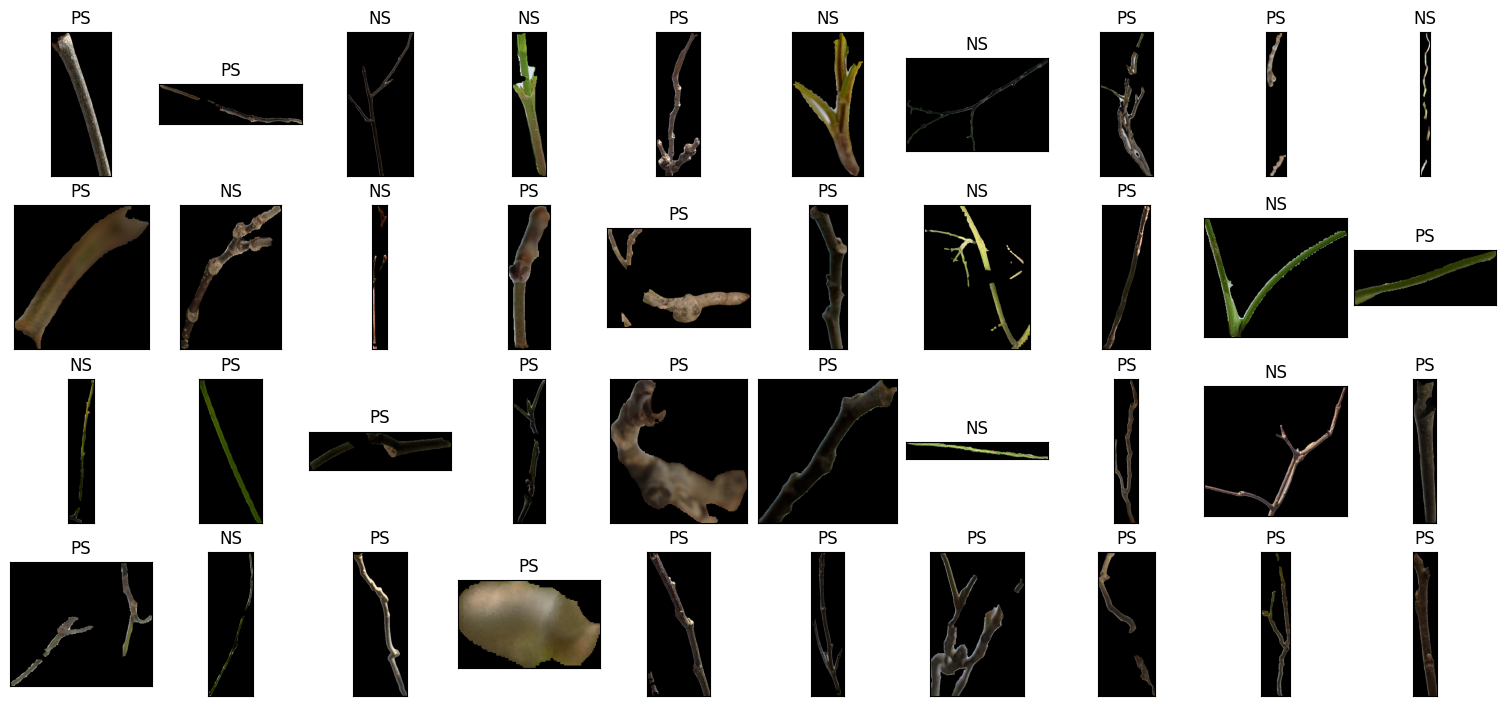

In [6]:
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

4. Label Category 분포 확인

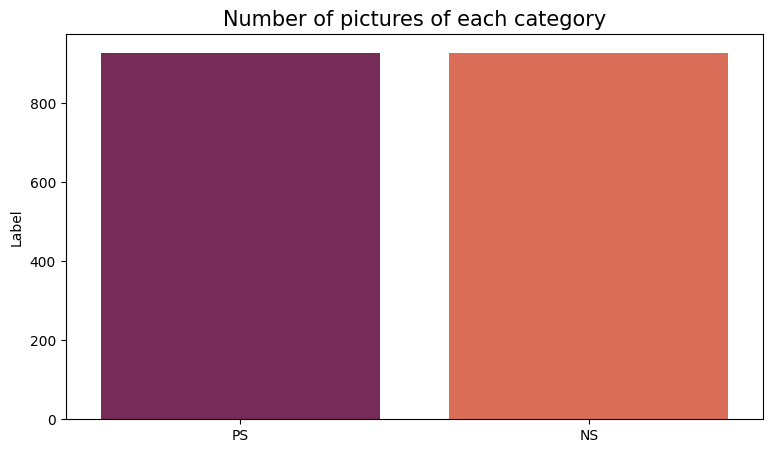

In [7]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

5. split

In [8]:
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((1670, 2), (186, 2))

데이터 증강

In [9]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

전이학습을 사용해서 모델 성능 높이기

In [10]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

Found 1503 validated image filenames belonging to 2 classes.
Found 167 validated image filenames belonging to 2 classes.
Found 186 validated image filenames belonging to 2 classes.




In [11]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
    # 라벨 개수가 8개이기 때문에 Dencs도 8로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [12]:
# Train모델 학습
for name, model in models.items():

    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)

    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

29084464/29084464 [==============================] - 0s 0us/step
DenseNet121          trained in 304.75 sec
9406464/9406464 [==============================] - 0s 0us/step
MobileNetV2          trained in 24.03 sec
74836368/74836368 [==============================] - 0s 0us/step
DenseNet201          trained in 31.77 sec
16705208/16705208 [==============================] - 0s 0us/step
EfficientNetB0       trained in 19.29 sec
27018416/27018416 [==============================] - 0s 0us/step
EfficientNetB1       trained in 22.39 sec
87910968/87910968 [==============================] - 1s 0us/step
InceptionV3          trained in 21.03 sec
12683000/12683000 [==============================] - 0s 0us/step
MobileNetV3Large     trained in 24.79 sec
234545216/234545216 [==============================] - 1s 0us/step
ResNet152V2          trained in 30.13 sec
94765736/94765736 [==============================] - 0s 0us/step
ResNet50             trained in 17.41 sec
94668760/94668760 [=================

Test 데이터로 성능 확인

In [13]:
# test데이터로 모델 성능 예측
for name, model in models.items():

    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')

# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1],
                          models[name]['acc'],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

6/6 [==============================] - 31s 6s/step
**DenseNet121 has a 70.97% accuracy on the test set**
6/6 [==============================] - 2s 298ms/step
**MobileNetV2 has a 74.73% accuracy on the test set**
6/6 [==============================] - 6s 557ms/step
**DenseNet201 has a 77.96% accuracy on the test set**
6/6 [==============================] - 3s 294ms/step
**EfficientNetB0 has a 54.30% accuracy on the test set**
6/6 [==============================] - 3s 225ms/step
**EfficientNetB1 has a 51.08% accuracy on the test set**
6/6 [==============================] - 4s 521ms/step
**InceptionV3 has a 68.82% accuracy on the test set**
6/6 [==============================] - 3s 339ms/step
**MobileNetV3Large has a 58.06% accuracy on the test set**
6/6 [==============================] - 5s 492ms/step
**ResNet152V2 has a 68.82% accuracy on the test set**
6/6 [==============================] - 3s 307ms/step
**ResNet50 has a 64.52% accuracy on the test set**
6/6 [==========================

,model,val_accuracy,accuracy,Training time (sec)
0,DenseNet201,0.7964,0.7796,31.77
1,MobileNetV2,0.7665,0.7473,24.03
2,ResNet50V2,0.7365,0.7473,15.82
3,Xception,0.7066,0.7258,19.22
4,VGG16,0.7365,0.7204,13.42
5,VGG19,0.6886,0.7151,23.48
6,DenseNet121,0.7066,0.7097,304.75
7,InceptionV3,0.6587,0.6882,21.03
8,ResNet152V2,0.7126,0.6882,30.13
9,ResNet50,0.5868,0.6452,17.41


시각화

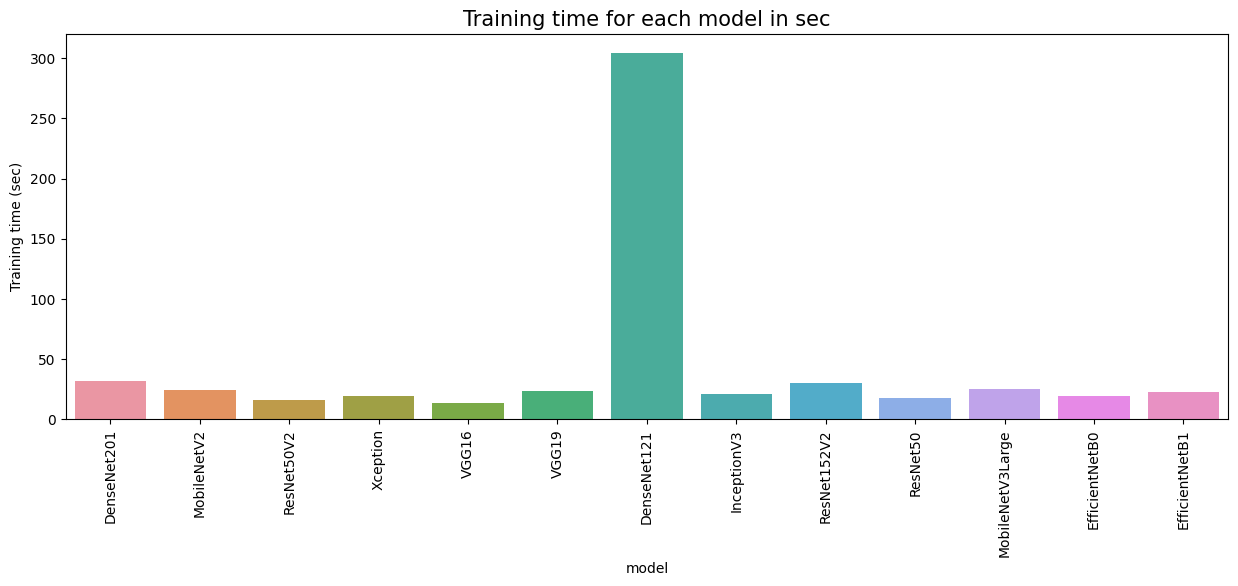

In [14]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

## 성능 좋은 모델1 -DenseNet201

In [15]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,validation_data=val_images,epochs=7)

Found 1503 validated image filenames belonging to 2 classes.
Found 167 validated image filenames belonging to 2 classes.
Found 186 validated image filenames belonging to 2 classes.
Epoch 1/7
47/47 [==============================] - 31s 301ms/step - loss: 0.4930 - accuracy: 0.7525 - val_loss: 0.4114 - val_accuracy: 0.8144
Epoch 2/7
47/47 [==============================] - 15s 309ms/step - loss: 0.3708 - accuracy: 0.8323 - val_loss: 0.4335 - val_accuracy: 0.7725
Epoch 3/7
47/47 [==============================] - 12s 245ms/step - loss: 0.2986 - accuracy: 0.8683 - val_loss: 0.3530 - val_accuracy: 0.8263
Epoch 4/7
47/47 [==============================] - 10s 222ms/step - loss: 0.2607 - accuracy: 0.8862 - val_loss: 0.4848 - val_accuracy: 0.7844
Epoch 5/7
47/47 [==============================] - 11s 227ms/step - loss: 0.2468 - accuracy: 0.8969 - val_loss: 0.4050 - val_accuracy: 0.7964
Epoch 6/7
47/47 [==============================] - 11s 231ms/step - loss: 0.2335 - accuracy: 0.9029 - val_los

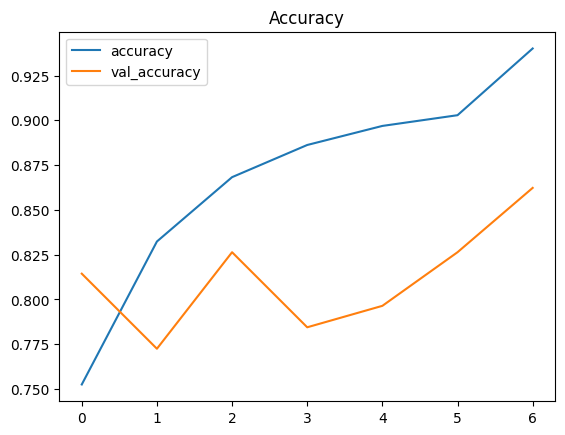

In [16]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

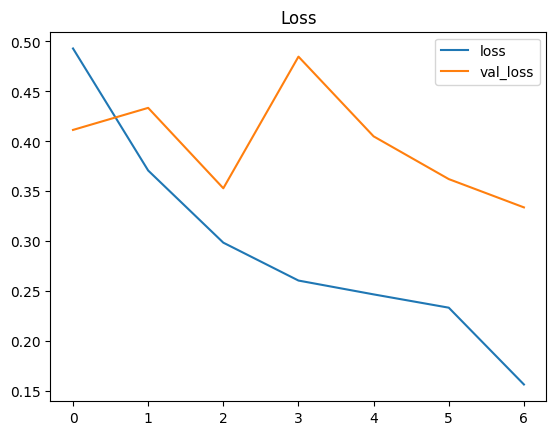

In [17]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [18]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

6/6 [==============================] - 5s 191ms/step
Accuracy on the test set: 83.87%


In [19]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

          NS       0.88      0.78      0.83        93
          PS       0.81      0.89      0.85        93

    accuracy                           0.84       186
   macro avg       0.84      0.84      0.84       186
weighted avg       0.84      0.84      0.84       186



## 성능 좋은 모델 예측 2 -MobileNetV2

In [20]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.MobileNetV2)
history = model.fit(train_images,validation_data=val_images,epochs=7)

Found 1503 validated image filenames belonging to 2 classes.
Found 167 validated image filenames belonging to 2 classes.
Found 186 validated image filenames belonging to 2 classes.
Epoch 1/7
47/47 [==============================] - 14s 223ms/step - loss: 0.5908 - accuracy: 0.6886 - val_loss: 0.5292 - val_accuracy: 0.7006
Epoch 2/7
47/47 [==============================] - 9s 200ms/step - loss: 0.4082 - accuracy: 0.8110 - val_loss: 0.4056 - val_accuracy: 0.7844
Epoch 3/7
47/47 [==============================] - 9s 187ms/step - loss: 0.3357 - accuracy: 0.8450 - val_loss: 0.3932 - val_accuracy: 0.7964
Epoch 4/7
47/47 [==============================] - 10s 213ms/step - loss: 0.2775 - accuracy: 0.8882 - val_loss: 0.3840 - val_accuracy: 0.8144
Epoch 5/7
47/47 [==============================] - 10s 222ms/step - loss: 0.2569 - accuracy: 0.8935 - val_loss: 0.3953 - val_accuracy: 0.8383
Epoch 6/7
47/47 [==============================] - 10s 203ms/step - loss: 0.1841 - accuracy: 0.9288 - val_loss:

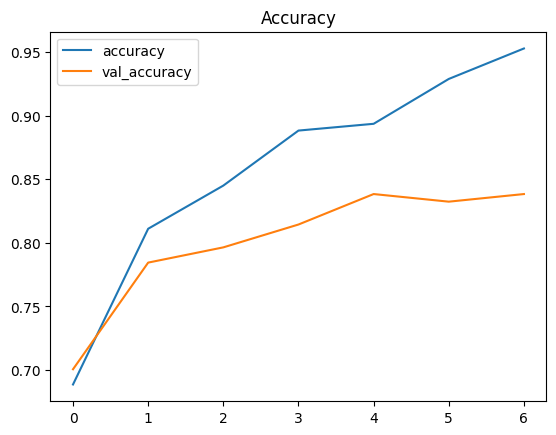

In [21]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

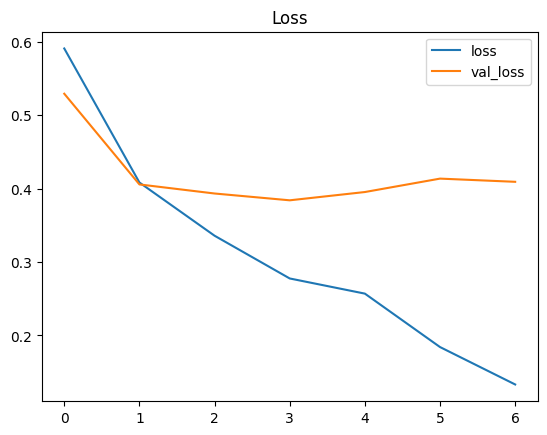

In [22]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [23]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

6/6 [==============================] - 2s 216ms/step
Accuracy on the test set: 81.72%


In [24]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

          NS       0.80      0.84      0.82        93
          PS       0.83      0.80      0.81        93

    accuracy                           0.82       186
   macro avg       0.82      0.82      0.82       186
weighted avg       0.82      0.82      0.82       186



## 성능 좋은 모델 예측 3 - ResNet50V2

In [25]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.ResNet50V2)
history = model.fit(train_images,validation_data=val_images,epochs=7)

Found 1503 validated image filenames belonging to 2 classes.
Found 167 validated image filenames belonging to 2 classes.
Found 186 validated image filenames belonging to 2 classes.
Epoch 1/7
47/47 [==============================] - 15s 234ms/step - loss: 0.5760 - accuracy: 0.7086 - val_loss: 0.5178 - val_accuracy: 0.7246
Epoch 2/7
47/47 [==============================] - 10s 212ms/step - loss: 0.3787 - accuracy: 0.8297 - val_loss: 0.5374 - val_accuracy: 0.7365
Epoch 3/7
47/47 [==============================] - 9s 195ms/step - loss: 0.2990 - accuracy: 0.8729 - val_loss: 0.5538 - val_accuracy: 0.7246
Epoch 4/7
47/47 [==============================] - 10s 210ms/step - loss: 0.2168 - accuracy: 0.9142 - val_loss: 0.5879 - val_accuracy: 0.7605
Epoch 5/7
47/47 [==============================] - 10s 211ms/step - loss: 0.1509 - accuracy: 0.9481 - val_loss: 0.6224 - val_accuracy: 0.7665
Epoch 6/7
47/47 [==============================] - 10s 204ms/step - loss: 0.1213 - accuracy: 0.9561 - val_loss

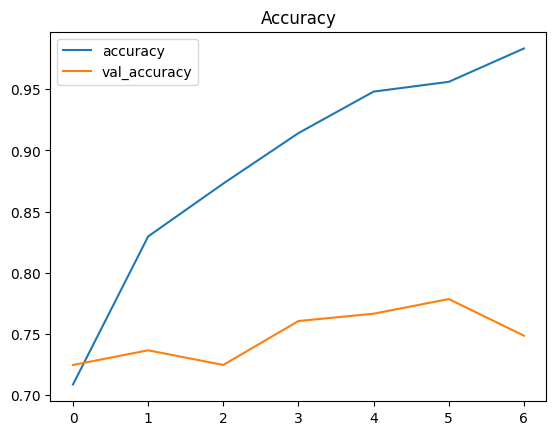

In [26]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

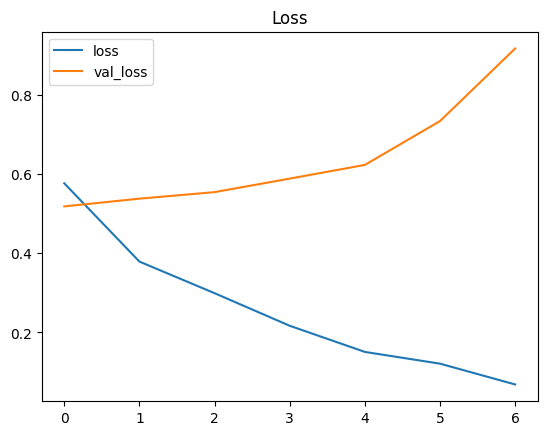

In [27]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [28]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

6/6 [==============================] - 2s 203ms/step
Accuracy on the test set: 72.58%


In [29]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

          NS       0.85      0.55      0.67        93
          PS       0.67      0.90      0.77        93

    accuracy                           0.73       186
   macro avg       0.76      0.73      0.72       186
weighted avg       0.76      0.73      0.72       186



## 실제 예측

In [30]:
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

번호를 입력하세요 : 10
1/1 [==============================] - 1s 1s/step


## 예측률 : 98.70%

### Class prediction = PS

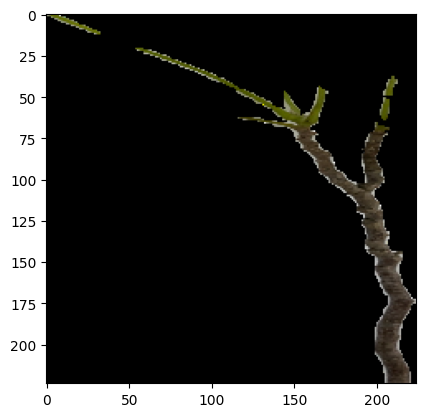

In [31]:
def printmd(string):
    # Print with Markdowns
    display(Markdown(string))
class_dictionary = {'NS': 0,
                    'PS': 1}
IMAGE_SIZE    = (224, 224)
number_1 = int(input("번호를 입력하세요 : ")) # 10, 50, 100
test_image = image.load_img(test_df.iloc[number_1, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"## 예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"### Class prediction = {x}")
    break

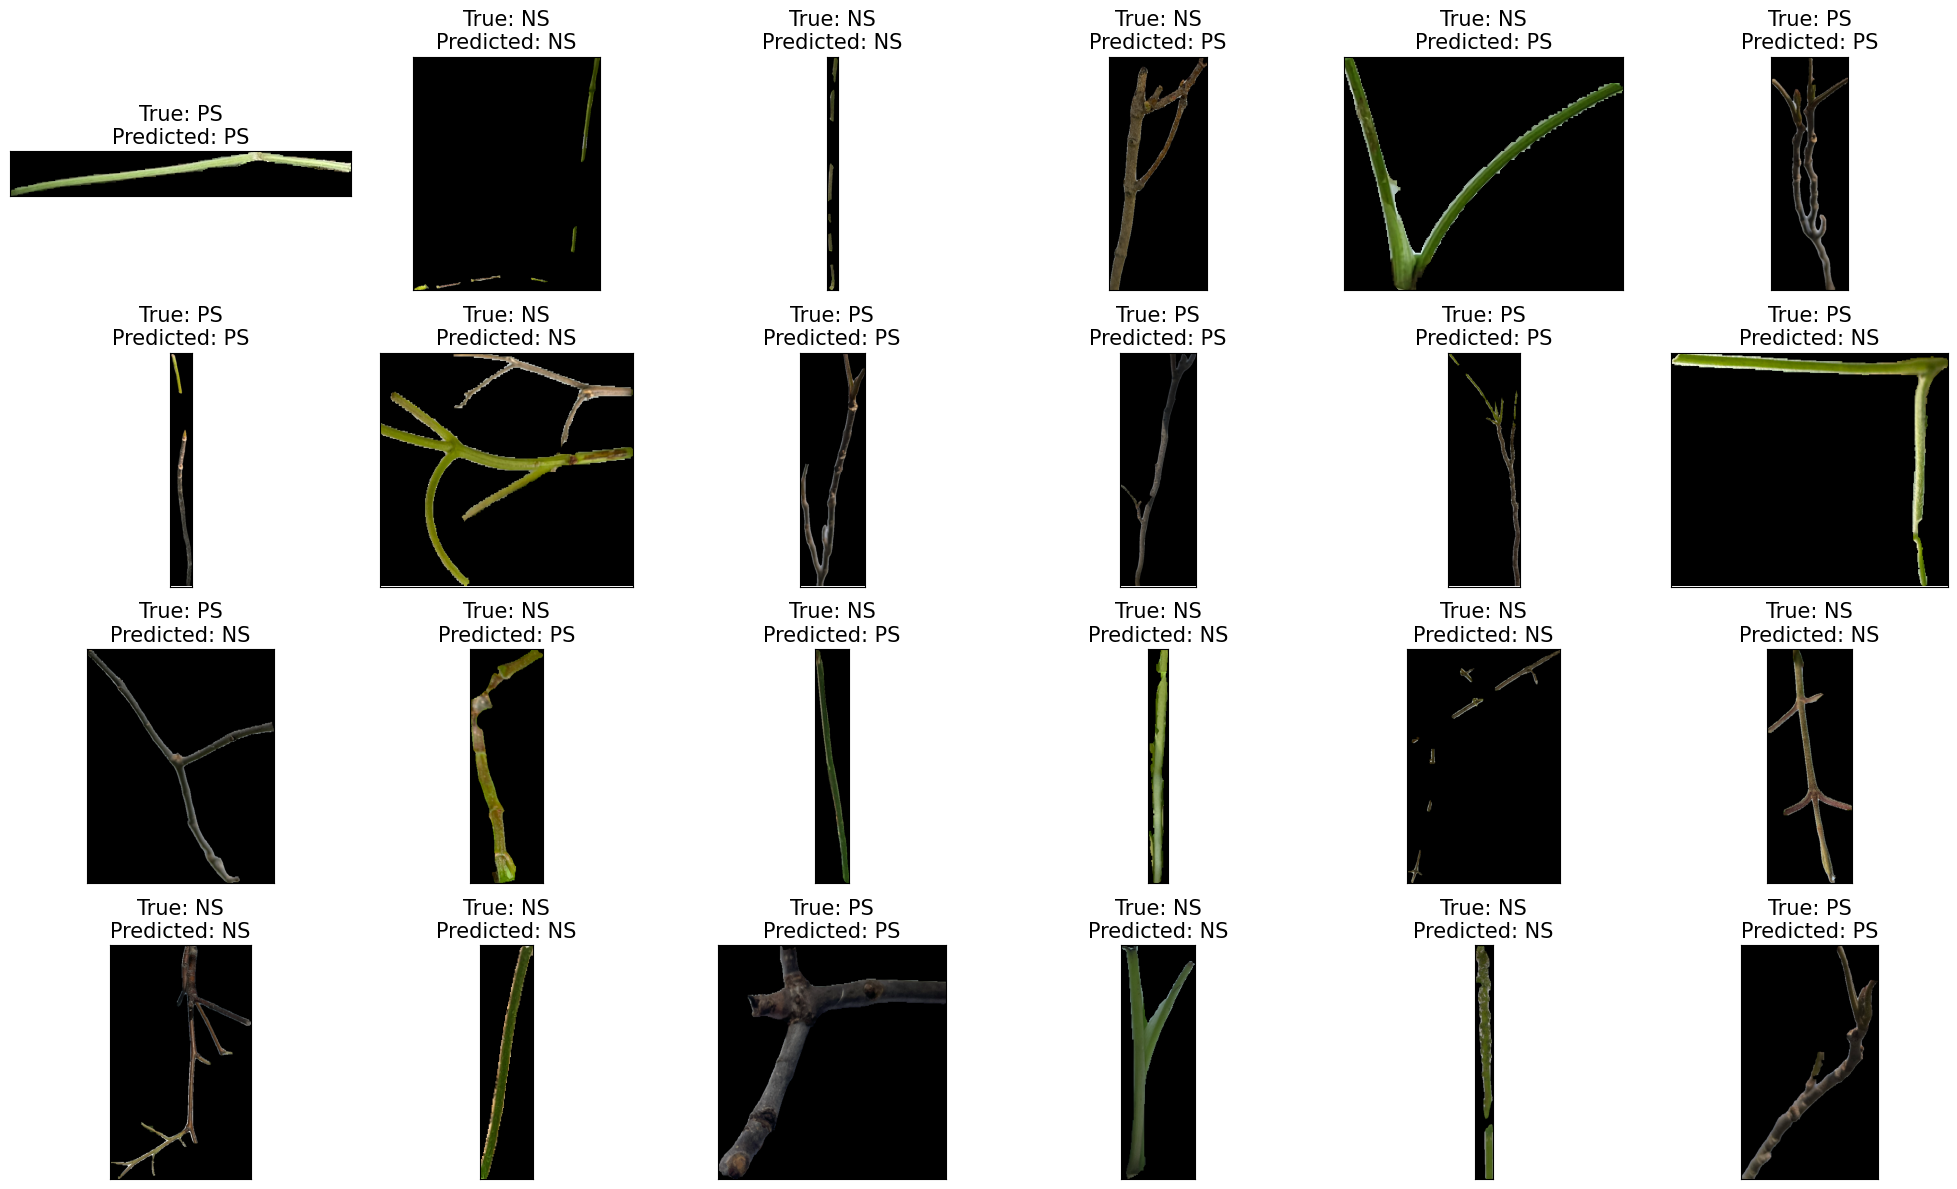

In [32]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()